In [32]:
import numpy as np
import pandas as pd
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from datetime import datetime
from pyproj import CRS
import string
from datetime import datetime
import osmnx as ox
import scipy
from sklearn import preprocessing, cluster

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [33]:
full_data = pd.read_excel('shanghai_gps.xlsx', skiprows=6, header=0)
full_data.columns = ['_'.join(name.lower().translate(str.maketrans(' ', ' ', string.punctuation)).split()) for name in full_data.columns]

In [34]:
len(full_data.end_time_in_seconds.unique())

10392

In [35]:
full_data.describe()

,uid,date_in_days,week,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,activitytrip,trip_mode,start_location,end_location,activity_type
count,10408.000000,10408.000000,10408.000000,1.040800e+04,1.040800e+04,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000,10408.000000
mean,2842.034493,16495.592045,3.176018,1.425239e+09,1.425243e+09,121.422001,31.192084,121.422014,31.191786,0.471464,1.880765,-0.231168,-0.218678,1.240680
std,2293.963747,197.220231,1.782481,1.704018e+07,1.704071e+07,0.133439,0.141343,0.133523,0.142475,0.499209,2.488351,0.797554,0.802387,1.389195
min,146.000000,15996.000000,0.000000,1.382053e+09,1.382053e+09,120.000050,30.000058,120.000079,30.000203,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,646.000000,16234.000000,2.000000,1.402620e+09,1.402621e+09,121.377204,31.153523,121.378311,31.153198,0.000000,0.000000,-1.000000,-1.000000,0.000000
50%,802.000000,16610.000000,3.000000,1.435149e+09,1.435152e+09,121.433450,31.209346,121.433493,31.209479,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5202.000000,16644.000000,5.000000,1.438097e+09,1.438098e+09,121.484058,31.265852,121.484527,31.265647,1.000000,4.000000,0.000000,0.000000,2.000000
max,5281.000000,16773.000000,6.000000,1.449234e+09,1.449235e+09,122.062761,31.999985,122.054907,31.999998,1.000000,8.000000,1.000000,1.000000,5.000000


In [36]:
full_data.isna().sum()

uid                      0
date_in_days             0
week                     0
start_time_in_seconds    0
end_time_in_seconds      0
start_longitude          0
start_latitude           0
end_longitude            0
end_latitude             0
activitytrip             0
trip_mode                0
start_location           0
end_location             0
activity_type            0
dtype: int64

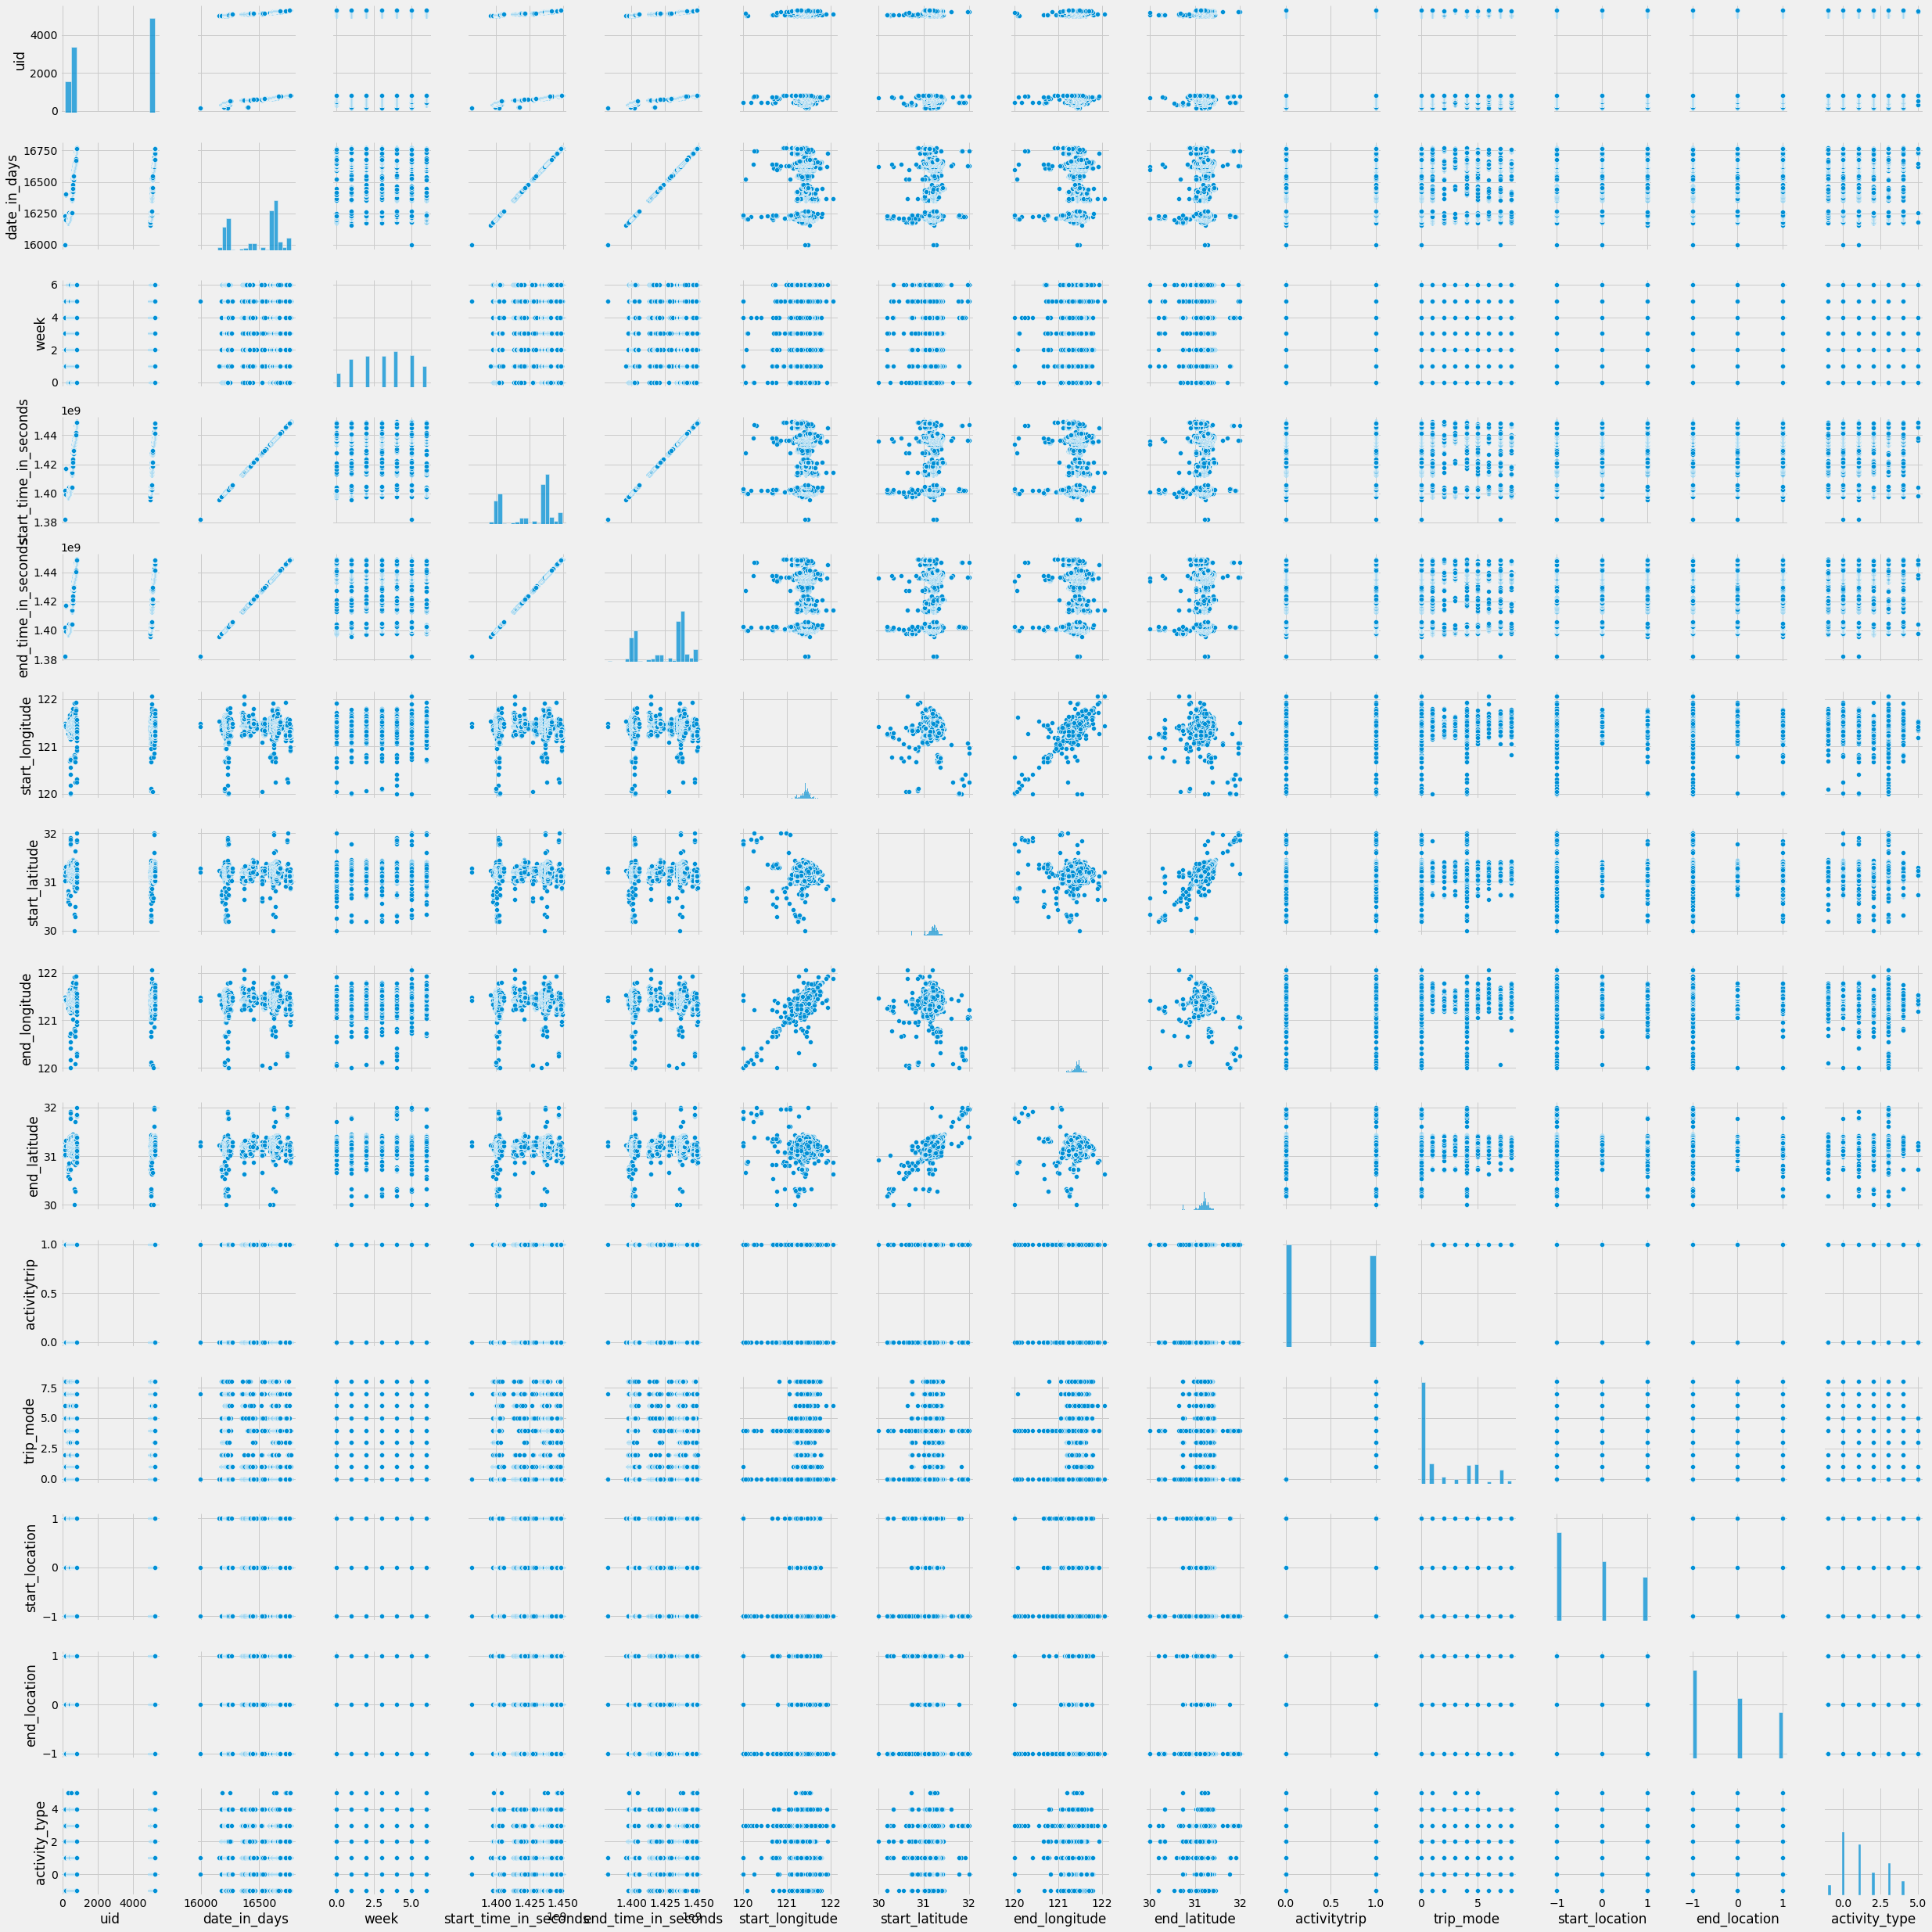

In [37]:
sns.pairplot(full_data)

activity_type           -0.381815
uid                     -0.066495
activitytrip            -0.039329
start_time_in_seconds   -0.033744
end_time_in_seconds     -0.033625
date_in_days            -0.033525
end_latitude            -0.030079
start_latitude          -0.028953
week                    -0.025488
trip_mode               -0.019798
start_longitude          0.029577
end_longitude            0.032796
start_location           0.524159
end_location             1.000000
Name: end_location, dtype: float64


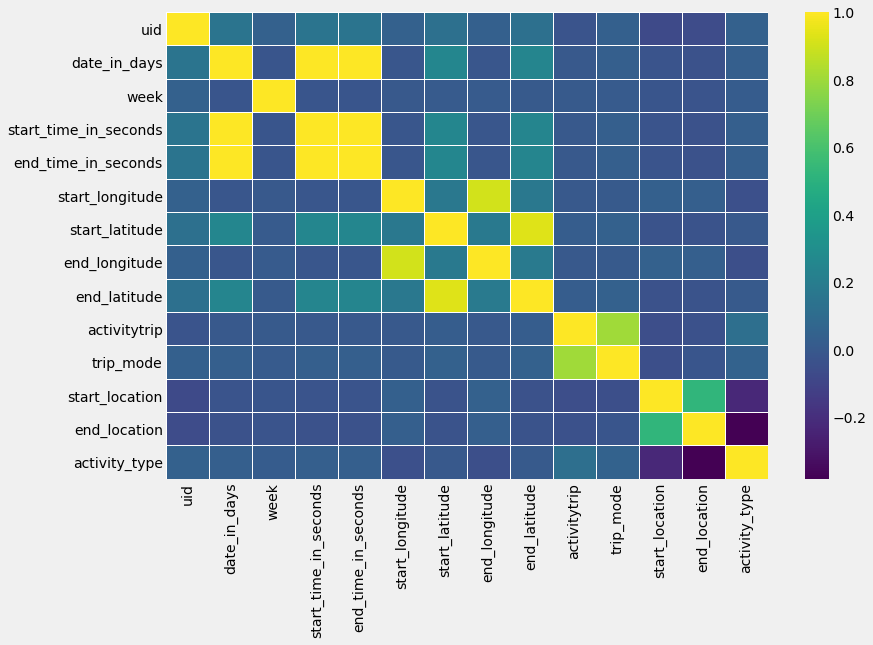

In [38]:
target_corr = full_data.corr()['end_location'].sort_values()
print(target_corr)
ax = sns.heatmap(full_data.corr(), annot=False, linewidths=0.5, cmap ='viridis')

<AxesSubplot:>

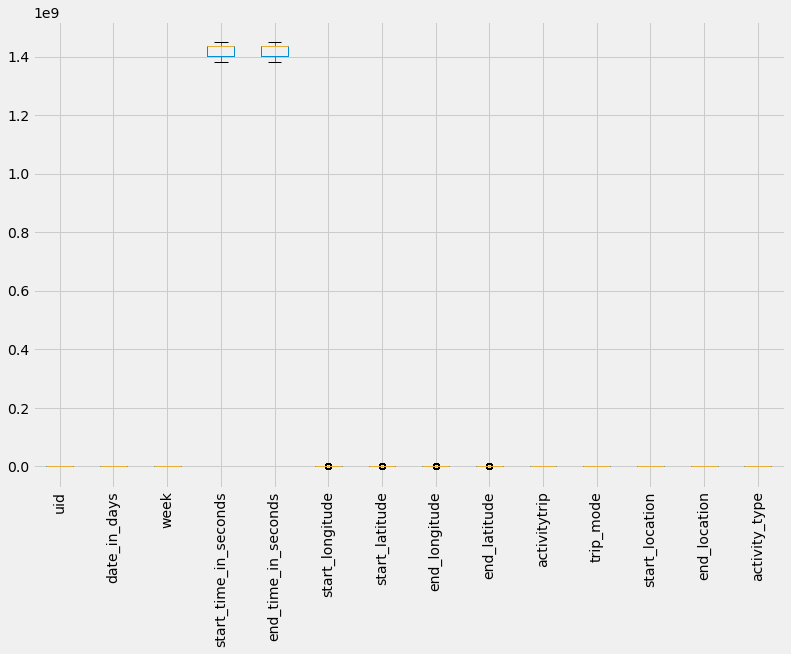

In [39]:
full_data.plot(kind='box', rot=90)

# Feature Engineering on Trips

## Datetime & Geolocational Features

In [40]:
full_data.drop(['date_in_days','week','activitytrip','trip_mode','start_location','end_location','activity_type'], axis=1,inplace=True)
full_data['label'] = 1

In [57]:
from geopy import distance
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce
import math

def transform_time(X):
        X = X.copy()
        # Engineer temporal features
        X['start_datetime'] = pd.to_datetime(X['start_time_in_seconds'],unit='s')
        X['end_datetime'] = pd.to_datetime(X['end_time_in_seconds'],unit='s')
        X['start_month'] = X['start_datetime'].dt.month
        X['start_day'] = X['start_datetime'].dt.day
        X['start_day_of_week'] = X['start_datetime'].dt.dayofweek
        X['start_hour_of_day'] = X['start_datetime'].dt.hour
        X['start_minute_of_hour'] = X['start_datetime'].dt.minute
        X['end_month'] = X['end_datetime'].dt.month
        X['end_day'] = X['end_datetime'].dt.day
        X['end_day_of_week'] = X['end_datetime'].dt.dayofweek
        X['end_hour_of_day'] = X['end_datetime'].dt.hour
        X['end_minute_of_hour'] = X['end_datetime'].dt.minute
#         X.drop(['start_time_in_seconds', 'end_time_in_seconds'], axis=1, inplace=True)
        return X
    
def calculate_great_circle_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    pickup = [start_latitude, start_longitude]
    dropoff = [end_latitude, end_longitude]
    dist = distance.great_circle(pickup, dropoff).km
    return dist

def calculate_manhattan_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    pickup = [start_latitude, start_longitude]
    dropoff_a = [start_latitude,end_longitude]
    dropoff_b = [end_latitude, start_longitude]
    distance_a = distance.great_circle(pickup, dropoff_a).km
    distance_b = distance.great_circle(pickup, dropoff_b).km
    return distance_a + distance_b

def calculate_bearing(start_latitude, start_longitude, end_latitude, end_longitude):
    d_lon = end_longitude-start_longitude
    y = math.sin(d_lon)*math.cos(end_latitude)
    x = math.cos(start_latitude)*math.sin(end_latitude) - math.sin(start_latitude)*math.cos(end_latitude)*math.cos(d_lon)
    bearing = math.atan2(y,x)
    if bearing < 0: 
        bearing+=2*math.pi
    return bearing

class TripTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y = None,he=None):
        X_ = X.copy()
        X_['duration_in_seconds'] = X_.apply(lambda x: x['end_time_in_seconds']-x['start_time_in_seconds'], axis=1)
        X_ = transform_time(X_)
        X_['gc_dist'] = X_.apply(lambda x: calculate_great_circle_distance(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
        X_['mn_dist'] = X_.apply(lambda x: calculate_manhattan_distance(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
        X_['bearing'] = X_.apply(lambda x: calculate_bearing(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
        if not he:
            he = ce.HashingEncoder(cols=['uid']).fit(X_)
        X_ = he.transform(X_)
        return X_

In [42]:
# lat_lng_data = new_data[['start_latitude','start_longitude','end_latitude','end_longitude']]
# new_data['gc_dist'] = new_data.apply(lambda x: calculate_great_circle_distance(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
# new_data['mn_dist'] = new_data.apply(lambda x: calculate_manhattan_distance(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)
# new_data['bearing'] = new_data.apply(lambda x: calculate_bearing(x.start_latitude,x.start_longitude,x.end_latitude,x.end_longitude),axis=1)

In [58]:
trans_data = TripTransformer().transform(full_data)

C:\Users\wyand\anaconda3\envs\tf-gpu\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:

trans_data['user_tid'] = new_data.sort_values(['uid','start_time_in_seconds']).groupby(['uid']).cumcount()+1
y = trans_data.label
X = trans_data.copy().drop('label',axis=1)
he = ce.HashingEncoder(cols=['uid']).fit(X,y)
new_data = he.transform(X)

KeyError: 'uid'

In [59]:
new_data = trans_data
new_data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,label,duration_in_seconds,start_datetime,end_datetime,start_month,start_day,start_day_of_week,start_hour_of_day,start_minute_of_hour,end_month,end_day,end_day_of_week,end_hour_of_day,end_minute_of_hour,gc_dist,mn_dist,bearing
0,0,0,0,1,0,0,0,0,1382053013,1382053037,121.483090,31.281703,121.483142,31.281787,1,24.0,2013-10-17 23:36:53,2013-10-17 23:37:17,10,17,3,23,36,10,17,3,23,37,0.010574,0.014313,0.555492
1,0,0,0,1,0,0,0,0,1382053282,1382056978,121.483192,31.281846,121.420448,31.207532,1,3696.0,2013-10-17 23:41:22,2013-10-18 00:42:58,10,17,3,23,41,10,18,4,0,42,10.191332,14.225922,3.830444
2,0,0,0,1,0,0,0,0,1382066805,1382066995,121.420343,31.207485,121.421642,31.206600,1,190.0,2013-10-18 03:26:45,2013-10-18 03:29:55,10,18,4,3,26,10,18,4,3,29,0.157957,0.221971,2.179451
3,0,0,0,1,0,0,0,0,1401056822,1401056998,121.431495,31.202385,121.431598,31.200608,1,176.0,2014-05-25 22:27:02,2014-05-25 22:29:58,5,25,6,22,27,5,25,6,22,29,0.197837,0.207444,3.084705
4,0,0,0,1,0,0,0,0,1401057000,1401059946,121.431599,31.200593,121.431700,31.024567,1,2946.0,2014-05-25 22:30:00,2014-05-25 23:19:06,5,25,6,22,30,5,25,6,23,19,19.573227,19.582868,3.141057


<AxesSubplot:>

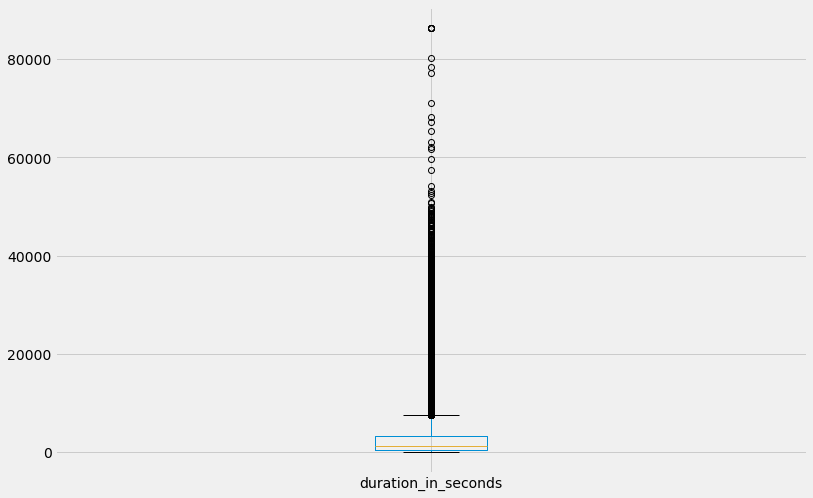

In [60]:
new_data.boxplot(column='duration_in_seconds')

In [66]:
# filtering outliers with zscore greater than 3 std
from scipy import stats
trip_data = new_data[(np.abs(stats.zscore(new_data.duration_in_seconds)) < 3)]
trip_data.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,start_time_in_seconds,end_time_in_seconds,start_longitude,start_latitude,end_longitude,end_latitude,label,duration_in_seconds,start_month,start_day,start_day_of_week,start_hour_of_day,start_minute_of_hour,end_month,end_day,end_day_of_week,end_hour_of_day,end_minute_of_hour,gc_dist,mn_dist,bearing
count,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,1.000400e+04,1.000400e+04,10004.000000,10004.000000,10004.000000,10004.000000,10004.0,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000
mean,0.095562,0.117853,0.106457,0.145442,0.144742,0.105058,0.139444,0.145442,1.425090e+09,1.425093e+09,121.422657,31.192379,121.422671,31.192061,1.0,2914.181327,6.780188,15.971012,2.686625,8.350060,29.344462,6.781387,15.979508,2.682727,8.064674,30.095262,3.012328,3.791588,3.018167
std,0.294004,0.322450,0.308438,0.352563,0.351858,0.306643,0.346427,0.352563,1.707296e+07,1.707323e+07,0.133712,0.141631,0.133798,0.142799,0.0,5022.216143,2.200389,9.254365,1.843865,6.649492,17.373559,2.200963,9.256326,1.831090,6.056675,17.418771,7.610226,9.607577,1.908463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.382053e+09,1.382053e+09,120.000050,30.000058,120.000079,30.000203,1.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.402569e+09,1.402570e+09,121.379813,31.154308,121.380573,31.153946,1.0,388.000000,6.000000,8.000000,1.000000,3.000000,14.000000,6.000000,8.000000,1.000000,3.000000,15.000000,0.046866,0.057486,1.313971
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.435128e+09,1.435139e+09,121.433939,31.209379,121.434162,31.209487,1.0,1085.000000,7.000000,16.000000,3.000000,8.000000,30.000000,7.000000,16.000000,3.000000,8.000000,30.000000,0.256439,0.324375,3.063025
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.438079e+09,1.438082e+09,121.484083,31.266387,121.484533,31.266377,1.0,2859.000000,8.000000,24.000000,4.000000,11.000000,44.000000,8.000000,24.000000,4.000000,11.000000,45.000000,2.646320,3.259377,4.643523
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.449234e+09,1.449235e+09,122.062761,31.999985,122.054907,31.999998,1.0,29567.000000,12.000000,31.000000,6.000000,23.000000,59.000000,12.000000,31.000000,6.000000,23.000000,59.000000,157.917356,206.588807,6.282447


<AxesSubplot:>

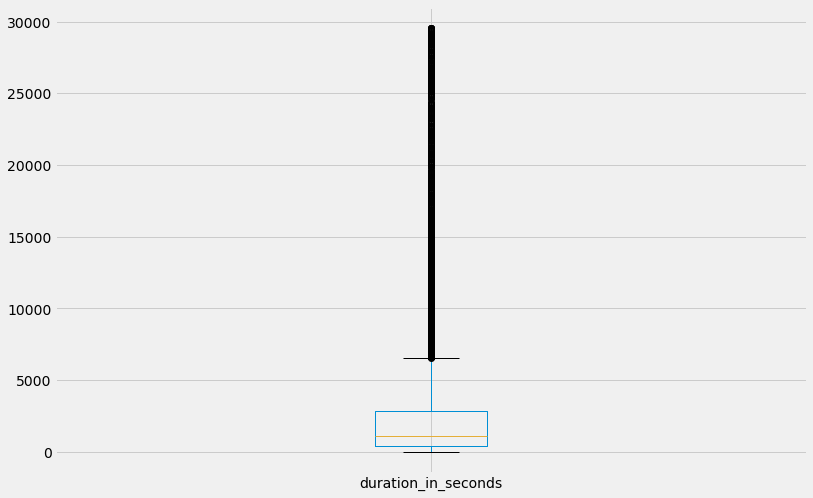

In [67]:
trip_data.boxplot(column='duration_in_seconds')

## Model

In [63]:
numerical_cols = list(clean_data.dtypes[(new_data.dtypes != 'object') & (new_data.dtypes != 'datetime64[ns]')].index)
# numerical_cols.remove('tid')
numeric_df = new_data[numerical_cols]
print(numerical_cols)
print(len(numerical_cols))
print(numeric_df.shape)
# print(numerical_cols)

['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'start_time_in_seconds', 'end_time_in_seconds', 'start_longitude', 'start_latitude', 'end_longitude', 'end_latitude', 'label', 'duration_in_seconds', 'start_month', 'start_day', 'start_day_of_week', 'start_hour_of_day', 'start_minute_of_hour', 'end_month', 'end_day', 'end_day_of_week', 'end_hour_of_day', 'end_minute_of_hour', 'gc_dist', 'mn_dist', 'bearing']
29
(10408, 28)


In [64]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10408 entries, 0 to 10407
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   col_0                  10408 non-null  int64  
 1   col_1                  10408 non-null  int64  
 2   col_2                  10408 non-null  int64  
 3   col_3                  10408 non-null  int64  
 4   col_4                  10408 non-null  int64  
 5   col_5                  10408 non-null  int64  
 6   col_6                  10408 non-null  int64  
 7   col_7                  10408 non-null  int64  
 8   start_time_in_seconds  10408 non-null  int64  
 9   end_time_in_seconds    10408 non-null  int64  
 10  start_longitude        10408 non-null  float64
 11  start_latitude         10408 non-null  float64
 12  end_longitude          10408 non-null  float64
 13  end_latitude           10408 non-null  float64
 14  duration_in_seconds    10408 non-null  float64
 15  st

In [ ]:
start_df = new_data[['uid', 'start_time_in_seconds', 'start_longitude', 'start_latitude', 'start_month', 'start_day', 'start_day_of_week','start_hour_of_day','start_minute_of_hour']]
end_df = new_data[['uid', 'end_time_in_seconds', 'end_longitude', 'end_latitude', 'end_month', 'end_day', 'end_day_of_week','end_hour_of_day','end_minute_of_hour']]
end_df.columns = start_df.columns
visit_gdf = pd.concat([start_df,end_df])

In [ ]:
temp_gdf = temp_gdf[['uid','start_time_in_seconds','start_longitude','start_latitude']]
temp_gdf.columns = ['uid','timestamp','longitude','latitude']

In [ ]:
temp_gdf.boxplot(column='timestamp')

In [ ]:
# temp_gdf['timestamp'] = pd.to_datetime(temp_gdf.timestamp, unit='s')

In [ ]:
temp_gdf.isna().sum()
temp_gdf.head()

In [ ]:
print(tdf.datetime.sample(30))

In [ ]:
gdf = gpd.GeoDataFrame(temp_gdf, geometry=gpd.points_from_xy(temp_gdf.longitude, temp_gdf.latitude))
# temp_gdf.timestamp.describe()

In [ ]:
gdf.head()

In [ ]:
G = ox.graph_from_place('Shanghai, China', network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True)
fig, ax = ox.plot_graph(G, show=False, close=False)
# ax.scatter(gdf['longitude'], gdf['latitude'], c=gdf.color)
lat = temp_gdf.latitude
lng = temp_gdf.longitude
# sns.kdeplot(x=lng, y=lat, cmap="magma", shade=True, thresh=0.05)
sns.scatterplot(x=lng,y=lng,color='g')
plt.show()

In [ ]:
import geoplot as gplt
import geoplot.crs as gcrs
G = ox.graph_from_place('Shanghai, China', network_type='walk', simplify=True, retain_all=False, truncate_by_edge=True)

In [ ]:
Gp = ox.project_graph(G)
Gc = ox.consolidate_intersections(Gp, rebuild_graph=True, tolerance=20, dead_ends=False)
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [ ]:
nodes.info()

In [ ]:
points_list = gpd.GeoSeries(gdf.geometry.to_list(),crs="EPSG:4326")
points_proj = points_list.to_crs(Gp.graph['crs'])

In [ ]:
gdf['nearest_node'] = ox.distance.nearest_nodes(G, gdf.longitude.to_numpy(), gdf.latitude.to_numpy())
nns = gdf.nearest_node.values.tolist()
nodes['visits'] = nodes.index.map(lambda x: nns.count(x))
nodes.describe()

In [ ]:
user_df = gdf.groupby(['uid', 'nearest_node']).timestamp.count().reset_index(name='count')

In [ ]:
node_df = user_df.pivot(index='uid', columns='nearest_node', values='count').fillna(0)

In [ ]:
R = node_df.values
user_visits_mean = np.mean(R, axis = 1)
R_demeaned = R - user_visits_mean.reshape(-1, 1)

In [ ]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)
all_user_predicted_visits = np.dot(np.dot(U,sigma),Vt)+user_visits_mean.reshape(-1, 1)

In [ ]:
G2 = ox.graph_from_gdfs(nodes,edges)
# nc = ox.plot.get_node_colors_by_attr(G2,'visits', num_bins=20)
ox.plot_graph(G2,node_size=nodes['visits'], node_color=nodes['visits'])

In [ ]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.scatter(gdf['longitude'], gdf['latitude'], c=gdf.uid)

In [ ]:

model = cluster.DBSCAN()
dtf = gdf.copy()
X = gdf[['latitude','longitude']]
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)


# closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
#                      dtf_X.drop("cluster", axis=1).values)
# dtf_X["centroids"] = 0
# for i in closest:
#     dtf_X["centroids"].iloc[i] = 1
# dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

In [ ]:
import geopy
city = "Shanghai"
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

In [ ]:
import movingpandas as mpd
true_gdf = gdf[['geometry','timestamp']].sort_values(by='timestamp')
true_gdf.info()
traj = mpd.Trajectory(true_gdf,1)

In [ ]:
import statistics
anomaly_fraction = 2.8/1000

In [ ]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(contamination=anomaly_fraction)
model.fit(temp_gdf)

In [ ]:
anomaly_fraction = 0.002 # max prevalence of abduction

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
train, df_test = train_test_split(numeric_df)
df_train, df_valid = train_test_split(train)
df_train.shape, df_valid.shape, df_test.shape

In [ ]:
# Isolation Forest ----
from sklearn.ensemble import IsolationForest
# training the model
clf = IsolationForest(random_state=13)
clf.fit(df_train)
# predictions
y_pred_train = clf.predict(df_train)
y_pred_test = clf.predict(df_test)
# y_pred_outliers = clf.predict(X_outliers)

In [ ]:
fig, axs = plt.subplots(11, 2, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(numerical_cols):
    isolation_forest = IsolationForest(contamination=anomaly_fraction)
    isolation_forest.fit(numeric_df[column].values.reshape(-1,1))

    xx = np.linspace(numeric_df[column].min(), numeric_df[column].max(), len(numeric_df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [ ]:
# perform normalization and PCA and output components
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
X_normalized = pd.DataFrame(normalize(StandardScaler().fit_transform(numeric_df)))

pca_99 = PCA(n_components = 0.99)
pca_99.fit(X_normalized)
reduced = pca_99.transform(X_normalized)

X_pc = PCA(n_components = 2).fit_transform(X_normalized)
X_principal = pd.DataFrame(X_pc)
X_principal.columns = ['P1', 'P2']

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
import matplotlib
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=anomaly_fraction),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=anomaly_fraction),
    "Isolation Forest" : IsolationForest(contamination=anomaly_fraction),
    "OCSVM": OneClassSVM(nu=0.25, gamma=0.35)}
colors = ['m', 'g', 'b', 'r']
legend1 = {}
legend2 = {}

X1 = X_pc

xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-2, 2, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize=(10,10))
    clf.fit(X_principal)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    legend1[clf_name] = plt.contour(
        xx, yy, Z, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on principle components")
plt.scatter(X_principal['P1'], X_principal['P2'], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
# plt.annotate("outlying points", xy=(4, 2),
#              xycoords="data", textcoords="data",
#              xytext=(3, 1.25), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0],
            legend1_values_list[3].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2], legend1_keys_list[3]),
           loc="upper right",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.ylabel("P2")
plt.xlabel("P1")

plt.show()